In [1]:
# imports
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer


In [2]:
def build_shor_encoding_circuit_standard():
    """
    Shor [[9,1,3]] code – standard qubit ordering:

    Blocks:
      (0,1,2), (3,4,5), (6,7,8)

    1. Phase-flip repetition (GHZ in X-basis)
    2. Bit-flip repetition inside each block
    """

    qc = QuantumCircuit(9, name="Shor_9_standard")

    # ==============================
    # 1) Phase-flip protection
    # ==============================
    # copy state to qubits 3 and 6
    qc.cx(0, 3)
    qc.cx(0, 6)

    # rotate into X basis
    qc.h(0)
    qc.h(3)
    qc.h(6)

    # ==============================
    # 2) Bit-flip protection (3-block repetition)
    # ==============================

    # Block 1: (0,1,2)
    qc.cx(0, 1)
    qc.cx(0, 2)

    # Block 2: (3,4,5)
    qc.cx(3, 4)
    qc.cx(3, 5)

    # Block 3: (6,7,8)
    qc.cx(6, 7)
    qc.cx(6, 8)

    return qc


shor_encoding_circuit = build_shor_encoding_circuit_standard()

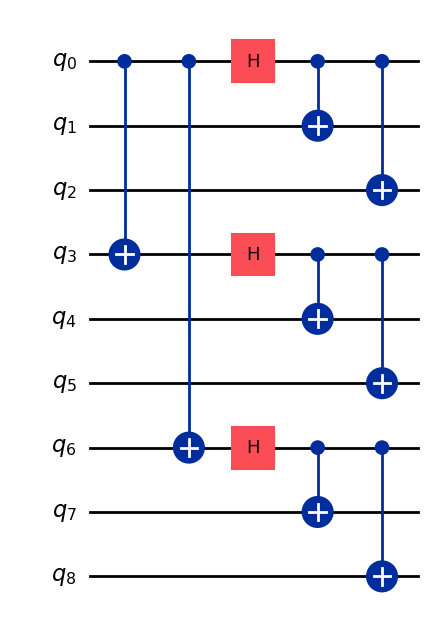

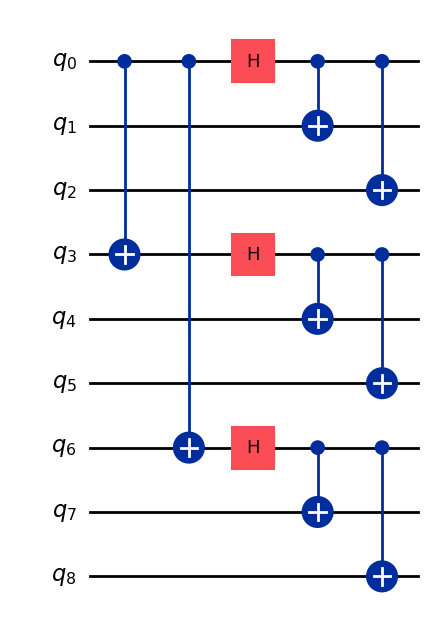

In [3]:
 #plot the Shor encoding circuit (matplotlib)

%matplotlib inline
shor_encoding_circuit.draw(output="mpl")


## Shor [[9,1,3]] Code – Stabilizer Verification

In this section we explicitly verify the stabilizer structure of the Shor [[9,1,3]] quantum error–correcting code using Qiskit.

The analysis is fully operator-based and aims to demonstrate three fundamental properties:

1. **Mutual commutation of the stabilizers**  
   All eight stabilizer generators commute with each other, confirming that the stabilizer group is Abelian and therefore defines a valid codespace.

2. **Compatibility of logical operators with the code**  
   The logical Pauli operators are
   $$
   Z_L = X^{\otimes 9}, \qquad X_L = Z^{\otimes 9}
   $$
   and they commute with all stabilizers, ensuring they preserve the codespace while acting non-trivially on the encoded logical qubit.

3. **Stabilization of the logical state**  
   By applying the Shor encoding circuit to the state $|0\rangle^{\otimes 9}$, we check that the resulting encoded state $|0_L\rangle$ is a +1 eigenstate of every stabilizer:
   $$
   S_i \, |0_L\rangle = |0_L\rangle \qquad \forall i
   $$
   which confirms that the encoding procedure correctly prepares a valid codeword in the Shor codespace.

This verification step ensures that both the **algebraic construction (stabilizers)** and the **circuit implementation (Qiskit)** of the Shor code are consistent.



In [4]:
#  imports (stabilizers)
import numpy as np

from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, Statevector


In [5]:
#  1. helper to build n-qubit Pauli operators

# Single-qubit Pauli matrices
I = np.array([[1, 0], [0, 1]], dtype=complex)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)

pauli_dict = {"I": I, "X": X, "Y": Y, "Z": Z}


def pauli_from_string(label: str) -> Operator:
    # leftmost char = qubit 8, rightmost = qubit 0  (Qiskit)
    op = pauli_dict[label[-1]]
    for c in reversed(label[:-1]):
        op = np.kron(pauli_dict[c], op)
    return Operator(op)



In [6]:
# 2. define stabilizers and logical operators

stabilizer_labels = [
    "ZZIIIIIII",   # S1 = Z0 Z1
    "IZZIIIIII",   # S2 = Z1 Z2
    "IIIZZIIII",   # S3 = Z3 Z4
    "IIIIZZIII",   # S4 = Z4 Z5
    "IIIIIIIZZ",   # S5 = Z6 Z7
    "IIIIIIZZI",   # S6 = Z7 Z8
    "XXXXXXIII",   # S7 = X0 X1 X2 X3 X4 X5
    "IIIXXXXXX",   # S8 = X3 X4 X5 X6 X7 X8
]

from qiskit.quantum_info import Operator




stabilizers = [pauli_from_string(s) for s in stabilizer_labels]



# Logical operators
logical_Z = pauli_from_string("XXXXXXXXX")  # X_L
logical_X = pauli_from_string("ZZZZZZZZZ")  # Z_L = Z0 Z1 Z2


In [7]:
# 3. check commutation between stabilizers

def commute(A: Operator, B: Operator, tol: float = 1e-10) -> bool:
    """
    Return True if [A,B] = 0 within numerical tolerance.
    """
    comm = A.data @ B.data - B.data @ A.data
    return np.allclose(comm, 0, atol=tol)


n = len(stabilizers)
print("Stabilizer commutation table (S_i with S_j):")
for i in range(n):
    row = []
    for j in range(n):
        row.append("C" if commute(stabilizers[i], stabilizers[j]) else "NC")
    print(f"S{i+1}: {row}")


Stabilizer commutation table (S_i with S_j):
S1: ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
S2: ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
S3: ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
S4: ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
S5: ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
S6: ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
S7: ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
S8: ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']


In [8]:
# 4. check commutation stabilizers <-> logical X_L, Z_L

print("Stabilizers vs logical X_L:")
for i, S in enumerate(stabilizers, start=1):
    print(f"S{i} with X_L:", "C" if commute(S, logical_X) else "NC")

print("\nStabilizers vs logical Z_L:")
for i, S in enumerate(stabilizers, start=1):
    print(f"S{i} with Z_L:", "C" if commute(S, logical_Z) else "NC")
    


Stabilizers vs logical X_L:
S1 with X_L: C
S2 with X_L: C
S3 with X_L: C
S4 with X_L: C
S5 with X_L: C
S6 with X_L: C
S7 with X_L: C
S8 with X_L: C

Stabilizers vs logical Z_L:
S1 with Z_L: C
S2 with Z_L: C
S3 with Z_L: C
S4 with Z_L: C
S5 with Z_L: C
S6 with Z_L: C
S7 with Z_L: C
S8 with Z_L: C


In [9]:
# 5. verify that |0_L> is +1 eigenstate of all stabilizers



enc = shor_encoding_circuit   # o build_shor_encoding_circuit_standard()
sv0 = Statevector.from_label("0"*9)
sv_enc = sv0.evolve(enc)

for i, S in enumerate(stabilizers, start=1):
    sv_S = sv_enc.evolve(S)
    plus_one = np.allclose(sv_S.data, sv_enc.data, atol=1e-10)
    print(f"S{i} |0_L> = +|0_L>?  ->", plus_one)

    



S1 |0_L> = +|0_L>?  -> True
S2 |0_L> = +|0_L>?  -> True
S3 |0_L> = +|0_L>?  -> True
S4 |0_L> = +|0_L>?  -> True
S5 |0_L> = +|0_L>?  -> True
S6 |0_L> = +|0_L>?  -> True
S7 |0_L> = +|0_L>?  -> True
S8 |0_L> = +|0_L>?  -> True


All conmutation is preserved, so the system has been set up properly.

In [10]:
# ----- |0_L> -----
sv_in = Statevector.from_label("0" * 9)
sv_0L = sv_in.evolve(shor_encoding_circuit)

# ----- |1_L> -----
qc_1L = QuantumCircuit(9)
qc_1L.x(0)  # prepare |1> on the logical input qubit
qc_1L = qc_1L.compose(shor_encoding_circuit)
sv_1L = Statevector.from_label("0" * 9).evolve(qc_1L)


def print_nonzero(label, sv, tol=1e-8):
    print(f"\n{label}:")
    for idx, amp in enumerate(sv.data):
        if abs(amp) > tol:
            basis = format(idx, "09b")  # binary string for the 9-qubit basis state
            print(f"|{basis}> : {amp}")


print_nonzero("|0_L>", sv_0L)
print_nonzero("|1_L>", sv_1L)


|0_L>:
|000000000> : (0.3535533905932737+0j)
|000000111> : (0.3535533905932737+0j)
|000111000> : (0.3535533905932737+0j)
|000111111> : (0.3535533905932737+0j)
|111000000> : (0.3535533905932737+0j)
|111000111> : (0.3535533905932737+0j)
|111111000> : (0.3535533905932737+0j)
|111111111> : (0.3535533905932737+0j)

|1_L>:
|000000000> : (0.3535533905932737+0j)
|000000111> : (-0.3535533905932737+0j)
|000111000> : (-0.3535533905932737+0j)
|000111111> : (0.3535533905932737+0j)
|111000000> : (-0.3535533905932737+0j)
|111000111> : (0.3535533905932737+0j)
|111111000> : (0.3535533905932737+0j)
|111111111> : (-0.3535533905932737+0j)


Which corresponds to the logical states given previously. Let´s move on to now use our 9-qubit error correction code.

## Error correction and some statistics

In [11]:
#  imports and basic Pauli matrices

import numpy as np

# Single-qubit Pauli matrices
I = np.array([[1, 0],
              [0, 1]], dtype=complex)

X = np.array([[0, 1],
              [1, 0]], dtype=complex)

Y = np.array([[0, -1j],
              [1j, 0]], dtype=complex)

Z = np.array([[1, 0],
              [0, -1]], dtype=complex)

pauli_map = {"I": I, "X": X, "Y": Y, "Z": Z}


In [12]:
#  build a n-qubit Pauli operator from a 9-char string

def pauli_string(label: str) -> np.ndarray:
    """
    Build a 9-qubit Pauli operator from a string like 'ZZIIIIIII'.

    Convention:
        label[0]  ->  qubit 8 (MSB)
        ...
        label[8]  -> qubit 0 (LSB)
    Returns:
        512x512 complex numpy array.
    """
    assert len(label) == 9, "Label must have length 9 for 9 qubits."

    # Start with qubit 0 (rightmost char)
    op = pauli_map[label[-1]]
    # Then prepend qubits 1..8
    for c in reversed(label[:-1]):
        op = np.kron(pauli_map[c], op)
    return op


In [13]:
# Cconstruct |0_L> and |1_L> as 512-dim vectors

dim = 2**9
zero_L = np.zeros(dim, dtype=complex)
one_L  = np.zeros(dim, dtype=complex)

amp = 1 / np.sqrt(8)

# Basis states that appear in |0_L> and |1_L>
# (exactly what you printed before)
bitstrings = [
    "000000000",
    "000000111",
    "000111000",
    "000111111",
    "111000000",
    "111000111",
    "111111000",
    "111111111",
]

# Signs for |1_L> relative to |0_L>
signs_1L = {
    "000000000": +1,
    "000000111": -1,
    "000111000": -1,
    "000111111": +1,
    "111000000": -1,
    "111000111": +1,
    "111111000": +1,
    "111111111": -1,
}

for b in bitstrings:
    idx = int(b, 2)  # |q8...q0>
    zero_L[idx] = amp
    one_L[idx]  = amp * signs_1L[b]

# Optional sanity check of normalization
print("||0_L||^2 =", np.vdot(zero_L, zero_L).real)
print("||1_L||^2 =", np.vdot(one_L, one_L).real)


||0_L||^2 = 0.9999999999999999
||1_L||^2 = 0.9999999999999999


In [16]:
#  Shor [[9,1,3]] stabilizers


# Pauli matrices (asegúrate de tener esto definido antes)
# I, X, Y, Z, pauli_map

def pauli_string(label: str) -> np.ndarray:
    """
    Build a 9-qubit Pauli operator as a 512x512 numpy array
    from a string like 'ZZIIIIIII'.

    Convention:
        label[0] -> qubit 8 (MSB)
        ...
        label[8] -> qubit 0 (LSB)
    """
    assert len(label) == 9
    op = pauli_map[label[-1]]  # start from qubit 0 (rightmost)
    for c in reversed(label[:-1]):
        op = np.kron(pauli_map[c], op)
    return op

# Rebuild stabilizers PURE NumPy
stabilizer_labels = [
    "ZZIIIIIII",   # S1
    "IZZIIIIII",   # S2
    "IIIZZIIII",   # S3
    "IIIIZZIII",   # S4
    "IIIIIIIZZ",   # S5
    "IIIIIIZZI",   # S6
    "XXXXXXIII",   # S7
    "IIIXXXXXX",   # S8
]

STABS = [pauli_string(s) for s in stabilizer_labels]

# Quick check
print("Type of STABS[0]:", type(STABS[0]))



def check_stabilized(state: np.ndarray, tol: float = 1e-10):
    """Check <ψ|S_i|ψ> ~ +1 for all stabilizers."""
    for i, S in enumerate(STABS, start=1):
        overlap = np.vdot(state, S @ state)
        print(f"S{i}: ⟨ψ|S_i|ψ⟩ = {overlap:.6f}")

print("Stabilizers on |0_L>:")
check_stabilized(zero_L)
print("\nStabilizers on |1_L>:")
check_stabilized(one_L)


Type of STABS[0]: <class 'numpy.ndarray'>
Stabilizers on |0_L>:
S1: ⟨ψ|S_i|ψ⟩ = 1.000000+0.000000j
S2: ⟨ψ|S_i|ψ⟩ = 1.000000+0.000000j
S3: ⟨ψ|S_i|ψ⟩ = 1.000000+0.000000j
S4: ⟨ψ|S_i|ψ⟩ = 1.000000+0.000000j
S5: ⟨ψ|S_i|ψ⟩ = 1.000000+0.000000j
S6: ⟨ψ|S_i|ψ⟩ = 1.000000+0.000000j
S7: ⟨ψ|S_i|ψ⟩ = 1.000000+0.000000j
S8: ⟨ψ|S_i|ψ⟩ = 1.000000+0.000000j

Stabilizers on |1_L>:
S1: ⟨ψ|S_i|ψ⟩ = 1.000000+0.000000j
S2: ⟨ψ|S_i|ψ⟩ = 1.000000+0.000000j
S3: ⟨ψ|S_i|ψ⟩ = 1.000000+0.000000j
S4: ⟨ψ|S_i|ψ⟩ = 1.000000+0.000000j
S5: ⟨ψ|S_i|ψ⟩ = 1.000000+0.000000j
S6: ⟨ψ|S_i|ψ⟩ = 1.000000+0.000000j
S7: ⟨ψ|S_i|ψ⟩ = 1.000000+0.000000j
S8: ⟨ψ|S_i|ψ⟩ = 1.000000+0.000000j


In [17]:
#  error operators and syndrome computation

def build_error(error_dict: dict) -> np.ndarray:
    """
    Build a 9-qubit Pauli error operator E from a dict {qubit: 'X'|'Y'|'Z'|'I'}.

    Qubit indices: 0..8 (0 = least significant / rightmost bit).
    Unspecified qubits are assumed to be 'I'.
    """
    chars = ['I'] * 9
    for q, P in error_dict.items():
        assert 0 <= q <= 8
        assert P in ['I', 'X', 'Y', 'Z']
        pos = 8 - q          # map qubit index -> string position
        chars[pos] = P
    label = ''.join(chars)
    return pauli_string(label)  # <-- now returns np.ndarray



def syndrome_bits(E: np.ndarray, tol: float = 1e-9) -> np.ndarray:
    """
    Compute the stabilizer syndrome s ∈ {+1,-1}^8 for a Pauli error E.

    s_i = +1  if [S_i, E] = 0  (commute)
    s_i = -1  if {S_i, E} = 0  (anticommute)
    """
    s = []
    for Si in STABS:
        comm  = np.linalg.norm(Si @ E - E @ Si)
        antic = np.linalg.norm(Si @ E + E @ Si)
        if comm < tol:
            s.append(+1)
        elif antic < tol:
            s.append(-1)
        else:
            s.append(np.nan)  # should not happen for pure Pauli strings
    return np.array(s, dtype=float)


# --- Examples ---
E_none = build_error({})
print("Syndrome (no error):", syndrome_bits(E_none).astype(int).tolist())

E_x_q0 = build_error({0: 'X'})
print("Syndrome (X on qubit 0):", syndrome_bits(E_x_q0).astype(int).tolist())

E_z_q4 = build_error({4: 'Z'})
print("Syndrome (Z on qubit 4):", syndrome_bits(E_z_q4).astype(int).tolist())


Syndrome (no error): [1, 1, 1, 1, 1, 1, 1, 1]
Syndrome (X on qubit 0): [1, 1, 1, 1, -1, 1, 1, 1]
Syndrome (Z on qubit 4): [1, 1, 1, 1, 1, 1, -1, -1]


Let’s explain the syndromes for the Shor [[9,1,3]] code.

We define the syndrome vector as

$$
s = (s_1, s_2, \dots, s_8), \qquad s_i \in \{+1, -1\}
$$

where each entry corresponds to one stabilizer $S_i$ in the following order:

$$
\begin{aligned}
S_1 &= Z_8 Z_7 \\
S_2 &= Z_7 Z_6 \\
S_3 &= Z_5 Z_4 \\
S_4 &= Z_4 Z_3 \\
S_5 &= Z_2 Z_1 \\
S_6 &= Z_1 Z_0 \\
S_7 &= X_8 X_7 X_6 X_5 X_4 X_3 \\
S_8 &= X_5 X_4 X_3 X_2 X_1 X_0
\end{aligned}
$$

with the qubit ordering

$$
\lvert q_8\, q_7\, q_6 \;|\; q_5\, q_4\, q_3 \;|\; q_2\, q_1\, q_0 \rangle .
$$

---

### No error

For the identity operator $E = I$,

$$
[S_i, E] = 0 \qquad \forall i
$$

hence the Syndrome (no error): [1, 1, 1, 1, 1, 1, 1, 1]


---

### Bit-flip error on qubit 0

For an $X$ error on qubit $0$, $E = X_0$,

$$
\{S_6, X_0\} = 0, \qquad [S_i, X_0] = 0 \ \ \forall\, i \neq 6
$$

because

$$
S_6 = Z_1 Z_0
$$

contains a $Z$ acting on the same qubit as the error, and

$$
\{X_0, Z_0\} = 0.
$$

Therefore, the syndrome is Syndrome (X on qubit 0): [1, 1, 1, 1, -1, 1, 1, 1]



The -1 appears in the 5th position of the array (Python index 4), but that position corresponds to **stabilizer $S_6$**, not to “qubit 5”.  

It simply indicates that the error **anticommutes with the stabilizer that acts on qubit $q_0$**.


This line of reasoning should be applied to any other error



In [18]:
#  precompute syndrome table for all single-qubit Pauli errors

def syndrome_table_single_errors():
    """
    Build a dictionary: syndrome (tuple of ints) -> (qubit, Pauli).

    It includes:
        - Identity (no error)
        - X/Y/Z on each qubit 0..8
    """
    table = {}
    # Identity
    E_id = build_error({})
    s_id = tuple(syndrome_bits(E_id).astype(int).tolist())
    table[s_id] = (None, 'I')

    for q in range(9):
        for P in ['X', 'Y', 'Z']:
            E = build_error({q: P})
            s = tuple(syndrome_bits(E).astype(int).tolist())
            # If collisions happen, they indicate degeneracy / multiple errors mapping
            if s in table and table[s] != (None, 'I'):
                # keep a note; for Shor with single-qubit errors this should not collide
                print(f"WARNING: Syndrome collision at {s}:",
                      "existing", table[s], "new", (q, P))
            else:
                table[s] = (q, P)
    return table

SYNDROME_TABLE = syndrome_table_single_errors()
print("Size of syndrome table:", len(SYNDROME_TABLE))


Size of syndrome table: 22


### Degeneracy and multiple–error syndromes in the Shor [[9,1,3]] code

The warnings are **not a bug**. They reflect a **degeneracy of the code**:

- A single **Z (phase) error** on any of the three qubits inside the *same block*  
  produces **exactly the same syndrome**.
- Therefore, the syndrome **identifies the block**, but **not the specific qubit** for phase errors.

Example:

 \(Z_0, Z_1, Z_2\) → same syndrome


\(Z_3, Z_4, Z_5\) → same syndrome


\(Z_6, Z_7, Z_8\) → same syndrome

This is expected:
> The Shor code is degenerate for **phase-flip errors** inside a block.

---

### What happens with **two errors**?

With two physical errors the syndrome is no longer unique: it can mimic a single–qubit error or even return the no–error syndrome, which makes the correction ambiguous or directly wrong. This is a direct consequence of the fact that the Shor code has distance $d=3$: it can correct exactly one error, detect up to two errors, but in general fails or becomes degenerate for two or more errors. Therefore, when two errors occur, the syndrome does not uniquely identify the true error pattern, and the decoder may apply an incorrect Pauli operator. This is precisely what the syndrome table “collisions” are showing.




In [ ]:
#  decode error from syndrome

def infer_error_from_syndrome(syndrome: np.ndarray):
    """
    Given a syndrome s ∈ {+1,-1}^8, return the most likely
    single-qubit Pauli error (q, P) using the precomputed table.

    Returns:
        (q, P) with q ∈ {0..8} or None, P ∈ {'I','X','Y','Z'}.
        If unknown, returns (None, None).
    """
    key = tuple(int(x) for x in syndrome)
    return SYNDROME_TABLE.get(key, (None, None))


# Quick check
E_test = build_error({3: 'Y'})
s_test = syndrome_bits(E_test)
print("Test syndrome:", s_test.astype(int).tolist())
print("Inferred error:", infer_error_from_syndrome(s_test))


Test syndrome: [1, 1, 1, -1, 1, 1, -1, -1]
Inferred error: (3, 'Y')


In [20]:
#  full error-correction round on the Shor code (state-level)

def logical_state(alpha: complex, beta: complex) -> np.ndarray:
    """Return |ψ_L> = α|0_L> + β|1_L> as a 512-dim vector."""
    psi = alpha * zero_L + beta * one_L
    # normalize just in case
    psi /= np.linalg.norm(psi)
    return psi


def apply_pauli_error(state: np.ndarray, error_dict: dict) -> np.ndarray:
    """Apply a Pauli error E (from error_dict) to the logical state."""
    E = build_error(error_dict)
    return E @ state


def apply_correction(state: np.ndarray, syndrome: np.ndarray):
    """Infer (q,P) from syndrome and apply the corresponding correction."""
    q, P = infer_error_from_syndrome(syndrome)
    if q is None or P is None or P == 'I':
        # No known / no error
        return state, (q, P)

    C = build_error({q: P})   # Pauli squares to identity (up to a phase)
    return C @ state, (q, P)


def decode_logical(state: np.ndarray):
    """
    Decode state by projecting onto {|0_L>, |1_L>} and returning (alpha, beta).
    """
    alpha_rec = np.vdot(zero_L, state)
    beta_rec  = np.vdot(one_L,  state)
    # You can renormalize if desired
    norm = np.sqrt(abs(alpha_rec)**2 + abs(beta_rec)**2)
    if norm > 0:
        alpha_rec /= norm
        beta_rec  /= norm
    return alpha_rec, beta_rec


def fidelity_logical(alpha, beta, alpha_rec, beta_rec):
    """F = |⟨ψ|ψ_rec⟩|^2 for |ψ⟩ = α|0_L>+β|1_L>."""
    overlap = np.conj(alpha)*alpha_rec + np.conj(beta)*beta_rec
    return abs(overlap)**2


def shor_single_round(alpha, beta, error_dict, verbose=True):
    """
    Perform a full single-round Shor-9 error-correction simulation:
      - logical input |ψ_L>
      - apply Pauli error
      - compute syndrome
      - correct
      - decode
      - return fidelity
    """
    psi_in = logical_state(alpha, beta)
    psi_err = apply_pauli_error(psi_in, error_dict)

    # Syndrome depends only on the error operator, not on |ψ_L>
    E = build_error(error_dict)
    s = syndrome_bits(E)

    psi_corr, correction = apply_correction(psi_err, s)
    alpha_rec, beta_rec = decode_logical(psi_corr)
    F = fidelity_logical(alpha, beta, alpha_rec, beta_rec)

    if verbose:
        print("="*60)
        print("Full Shor-9 error-correction demo")
        print("="*60)
        print(f"Input logical state: α={alpha:.3f}, β={beta:.3f}")
        print(f"Injected error: {error_dict}")
        print(f"Syndrome: {s.astype(int).tolist()}")
        print(f"Inferred correction: {correction}")
        print(f"Recovered logical state: α'={alpha_rec:.3f}, β'={beta_rec:.3f}")
        print(f"Fidelity: F = {F:.6f}")
        print("="*60)

    return {
        "alpha": alpha,
        "beta": beta,
        "error": error_dict,
        "syndrome": s.astype(int).tolist(),
        "correction": correction,
        "alpha_rec": alpha_rec,
        "beta_rec": beta_rec,
        "F": F,
    }


# Example usage:
res = shor_single_round(
    alpha=1/np.sqrt(2),
    beta=1/np.sqrt(2),
    error_dict={3: 'Y'},  # single Y error on qubit 3
    verbose=True
)


Full Shor-9 error-correction demo
Input logical state: α=0.707, β=0.707
Injected error: {3: 'Y'}
Syndrome: [1, 1, 1, -1, 1, 1, -1, -1]
Inferred correction: (3, 'Y')
Recovered logical state: α'=0.707+0.000j, β'=0.707+0.000j
Fidelity: F = 1.000000


### Full Shor-9 error-correction round (example)

We start with the logical state

$$
|\psi_L\rangle = \frac{1}{\sqrt{2}}|0_L\rangle + \frac{1}{\sqrt{2}}|1_L\rangle
$$

A **single physical error** is injected:

$$
E = Y_3
$$

which means a Pauli-\(Y = iXZ\) acts on **qubit 3**.



### Syndrome measurement

The measured stabilizer syndrome is

$$
Syndrome: [1, 1, 1, -1, 1, 1, -1, -1]
$$

This means:

- One of the **bit-flip stabilizers** anticommutes → tells us *which qubit inside the block* is affected.
- Both **phase-flip stabilizers** anticommute → tells us *which block* is affected.
- Combining both pieces of information uniquely identifies a \(Y\) error on **qubit 3**.



### Correction

The decoder infers the correction:


and applies

$$
C = Y_3
$$

Since Pauli operators square to the identity (up to a global phase):

$$
C \, E = Y_3 \, Y_3 = I
$$

the logical state is perfectly restored.



### Recovered state

After correction and decoding:

$$
|\psi_{\text{rec}}\rangle
= 0.707\,|0\rangle + 0.707\,|1\rangle
$$

The fidelity is

$$
F = |\langle \psi | \psi_{\text{rec}}\rangle|^2 = 1
$$

which confirms **perfect error correction** for a **single-qubit error**, as expected from a code with distance \(d=3\).

is working correctly!



In [21]:
# Monte Carlo over random single-qubit Pauli errors

rng = np.random.default_rng(seed=12345)

def random_logical_state():
    """Sample a random logical state on the Bloch sphere."""
    theta = rng.uniform(0, np.pi)
    phi   = rng.uniform(0, 2*np.pi)
    alpha = np.cos(theta / 2)
    beta  = np.exp(1j * phi) * np.sin(theta / 2)
    return alpha, beta

def random_single_error():
    """Sample a single-qubit Pauli error (possibly identity)."""
    q = rng.integers(0, 9)        # qubit 0..8
    P = rng.choice(['X', 'Y', 'Z'])
    return {q: P}

def monte_carlo_shor(n_trials=1000):
    success = 0
    for _ in range(n_trials):
        alpha, beta = random_logical_state()
        err = random_single_error()
        res = shor_single_round(alpha, beta, err, verbose=False)
        if res["F"] > 0.999:
            success += 1
    return success / n_trials

mc_success = monte_carlo_shor(n_trials=200)
print(f"Approx. success probability for single errors: {mc_success:.3f}")


Approx. success probability for single errors: 1.000


It works perfectly! (for single errors)

## Statistical analysis: multiple–error regime 
we move to a **Monte-Carlo analysis** to explore the  the code under multiple physical errors.

For each run we:

1. Generate a random logical state  
   $|\psi\rangle = \alpha |0\rangle + \beta |1\rangle$

2. Encode it into  
   $|\psi_L\rangle = \alpha |0_L\rangle + \beta |1_L\rangle$

3. Inject *k* random Pauli errors, with $k \in \{1,2,3\}$

4. Measure the stabilizer syndrome  
   $s = (s_1,\dots,s_8)$, with $s_i \in \{+1,-1\}$

5. Apply the inferred correction

6. Decode and compute the logical fidelity  
   $F = |\langle \psi | \psi_{\mathrm{rec}} \rangle|^2$

This procedure is repeated for many random instances, allowing us to estimate statistically:

- Mean logical fidelity vs number of errors
- Minimum observed fidelity
- Success probability  
  $P_{\text{succ}}(k) = \mathbb{P}(F > 0.999)$

Since the Shor code has distance $d=3$, the expected behaviour is:

- **1 error:** perfect correction $(F \approx 1)$
- **2 errors:** detection possible, but correction is ambiguous
- **3 or more errors:** correction typically fails

This Monte-Carlo study quantifies this breakdown and illustrates the transition from perfect protection to failure as the number of physical errors increases.


In [30]:
import numpy as np
#!pip install pandas matplotlib
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(seed=12345)

def random_logical_state(rng: np.random.Generator):
    """
    Sample a random logical state on the Bloch sphere:
        |ψ_L> = α|0_L> + β|1_L>
    """
    theta = rng.uniform(0, np.pi)
    phi   = rng.uniform(0, 2*np.pi)
    alpha = np.cos(theta / 2)
    beta  = np.exp(1j * phi) * np.sin(theta / 2)
    return alpha, beta

def random_error_dict(num_errors: int, rng: np.random.Generator):
    """
    Sample a random Pauli error pattern with `num_errors` non-identity errors.
    - Choose num_errors distinct physical qubits (0..8)
    - Assign X/Y/Z uniformly.
    """
    qubits = rng.choice(9, size=num_errors, replace=False)
    paulis = rng.choice(['X', 'Y', 'Z'], size=num_errors)
    return {int(q): str(P) for q, P in zip(qubits, paulis)}


In [31]:
def run_shor_statistics(n_total=1000, p_distribution=(0.9, 0.09, 0.01), seed=12345):
    """
    Run a statistical analysis of the Shor-9 code.

    - n_total: total number of random instances
    - p_distribution: probabilities for choosing num_errors = 1, 2, 3
    - seed: RNG seed for reproducibility

    For each case:
      1) Sample random logical state |ψ_L>
      2) Sample num_errors ∈ {1,2,3}
      3) Sample random error_dict with num_errors Pauli errors
      4) Run one full correction round (shor_single_round)
      5) Store fidelity, num_errors, and error pattern
    """
    rng = np.random.default_rng(seed=seed)
    results = []

    for case in range(n_total):
        # 1) logical state
        alpha, beta = random_logical_state(rng)

        # 2) number of errors (1,2,3)
        num_errors = rng.choice([1, 2, 3], p=p_distribution)

        # 3) random error pattern
        err = random_error_dict(num_errors, rng)

        # 4) single correction round (assumes shor_single_round is defined)
        out = shor_single_round(alpha, beta, err, verbose=False)

        results.append({
            "case": case,
            "num_errors": num_errors,
            "error_dict": err,
            "fidelity": out["F"],
            "alpha": alpha,
            "beta": beta,
            "alpha_rec": out["alpha_rec"],
            "beta_rec": out["beta_rec"],
        })

        if (case + 1) % 100 == 0:
            print(f"Processed {case + 1}/{n_total} cases...")

    df = pd.DataFrame(results)
    return df


In [32]:
df_results = run_shor_statistics(n_total=1000, p_distribution=(1/3, 1/3, 1/3), seed=2025)
df_results.to_csv("shor9_stats.csv", index=False)
df_results.head()


Processed 100/1000 cases...
Processed 200/1000 cases...
Processed 300/1000 cases...
Processed 400/1000 cases...
Processed 500/1000 cases...
Processed 600/1000 cases...
Processed 700/1000 cases...
Processed 800/1000 cases...
Processed 900/1000 cases...
Processed 1000/1000 cases...


,case,num_errors,error_dict,fidelity,alpha,beta,alpha_rec,beta_rec
0,0,3,"{6: 'X', 4: 'Y', 8: 'X'}",0.0,0.008706,-0.737527+0.675262j,0.000000+0.000000j,0.000000+0.000000j
1,1,1,{0: 'Y'},1.0,0.126026,-0.445535-0.886350j,0.126026+0.000000j,-0.445535-0.886350j
2,2,1,{3: 'Z'},1.0,0.935322,0.176331+0.306724j,0.935322+0.000000j,0.176331+0.306724j
3,3,2,"{2: 'X', 4: 'X'}",0.0,0.786390,0.569748+0.238702j,0.000000+0.000000j,0.000000+0.000000j
4,4,3,"{3: 'X', 0: 'X', 1: 'X'}",0.0,0.614122,-0.664084-0.426434j,0.000000+0.000000j,0.000000+0.000000j


In [33]:
def summarize_statistics(df: pd.DataFrame, success_threshold=0.999):
    """
    Print a text summary similar to your previous output:
    - number of cases per error count
    - mean fidelity, min fidelity
    - success rate (F > success_threshold)
    """
    print("\n" + "="*70)
    print("STATISTICAL ANALYSIS OF SHOR-9 ERROR CORRECTION")
    print("="*70 + "\n")

    grouped = df.groupby('num_errors')

    print(f"{'N° errors':<10} {'Cases':<10} {'F mean':<12} {'F min':<12} {'Success (>%.3f)' % success_threshold:<16}")
    print("-"*70)

    for k, g in grouped:
        n_cases = len(g)
        f_mean  = g['fidelity'].mean()
        f_min   = g['fidelity'].min()
        success_rate = (g['fidelity'] > success_threshold).sum() / n_cases * 100.0

        print(f"{k:<10d} {n_cases:<10d} {f_mean:<12.4f} {f_min:<12.4f} {success_rate:<15.1f}%")

    print("\nDetailed fidelity distribution by #errors:\n")

    for k, g in grouped:
        print(f"{k} error(s):")
        print(f"  mean   : {g['fidelity'].mean():.4f}")
        print(f"  std    : {g['fidelity'].std():.4f}")
        print(f"  median : {g['fidelity'].median():.4f}")
        print(f"  Q1–Q3  : {g['fidelity'].quantile(0.25):.4f} – {g['fidelity'].quantile(0.75):.4f}")
        print()

    return grouped


In [34]:
# Table: aggregated metrics per number of errors (for display in notebook)

def make_summary_table(df: pd.DataFrame, success_threshold=0.999):
    rows = []
    for k, g in df.groupby('num_errors'):
        n_cases = len(g)
        f_mean  = g['fidelity'].mean()
        f_min   = g['fidelity'].min()
        success = (g['fidelity'] > success_threshold).sum() / n_cases * 100.0
        rows.append({
            "num_errors": k,
            "cases": n_cases,
            "F_mean": f_mean,
            "F_min": f_min,
            f"success_%(F>{success_threshold})": success,
        })
    summary_df = pd.DataFrame(rows).sort_values("num_errors")
    return summary_df

summary_df = make_summary_table(df_results, success_threshold=0.999)
summary_df.style.format({
    "F_mean": "{:.4f}",
    "F_min": "{:.4f}",
    "success_%(F>0.999)": "{:.1f}"
})


,num_errors,cases,F_mean,F_min,success_%(F>0.999)
0,1,295,1.0000,1.0000,100.0
1,2,335,0.2146,0.0000,15.5
2,3,370,0.1025,0.0000,7.0


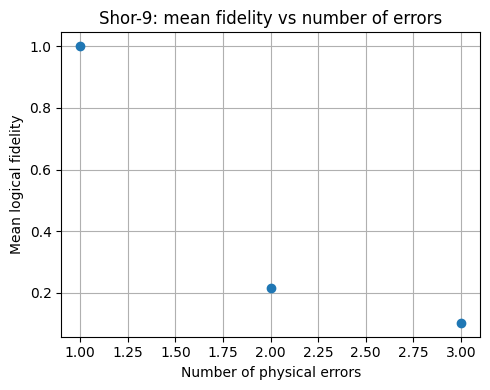

In [40]:
# Mean fidelity vs number of errors
plt.figure(figsize=(5, 4))
means = df_results.groupby('num_errors')['fidelity'].mean()
plt.plot(means.index, means.values, marker='o', linestyle='')
plt.xlabel("Number of physical errors")
plt.ylabel("Mean logical fidelity")
plt.title("Shor-9: mean fidelity vs number of errors")
plt.grid(True)
plt.tight_layout()
plt.show()


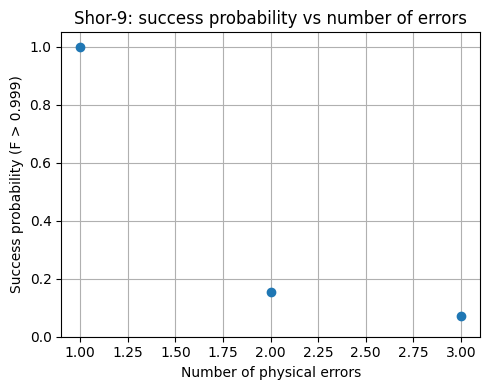

In [41]:
# Success probability (F > threshold) vs number of errors
success_threshold = 0.999
succ_rates = df_results.groupby('num_errors')['fidelity'].apply(
    lambda x: (x > success_threshold).mean()
)

plt.figure(figsize=(5, 4))
plt.plot(succ_rates.index, succ_rates.values, marker='o', linestyle='')
plt.xlabel("Number of physical errors")
plt.ylabel(f"Success probability (F > {success_threshold})")
plt.title("Shor-9: success probability vs number of errors")
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 600x400 with 0 Axes>

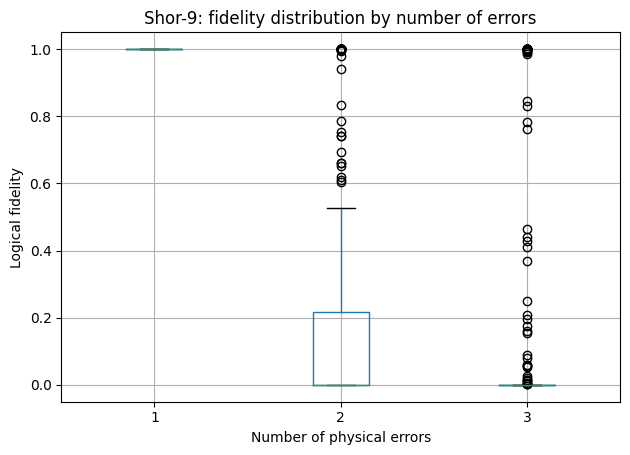

In [42]:
# Boxplot: fidelity distribution by number of errors
plt.figure(figsize=(6, 4))
df_results.boxplot(column='fidelity', by='num_errors')
plt.xlabel("Number of physical errors")
plt.ylabel("Logical fidelity")
plt.title("Shor-9: fidelity distribution by number of errors")
plt.suptitle("")  # remove automatic pandas title
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [43]:
# Success threshold
success_threshold = 0.999

# Success rate per number of physical errors
success_by_errors = (
    df_results
    .groupby('num_errors')['fidelity']
    .apply(lambda x: 100 * (x > success_threshold).mean())
)

#print("\nSuccess rate (%) by number of physical errors:\n")
#for k, v in success_by_errors.items():
#    print(f"{k} error(s): {v:.2f} %")
summary = (
    df_results
    .groupby('num_errors')['fidelity']
    .agg(
        mean_fidelity='mean',
        min_fidelity='min',
        success_rate=lambda x: 100 * (x > success_threshold).mean()
    )
)

print(summary)


            mean_fidelity  min_fidelity  success_rate
num_errors                                           
1                1.000000           1.0    100.000000
2                0.214555           0.0     15.522388
3                0.102538           0.0      7.027027


## Conclusions on the multiple error correction

The Monte-Carlo simulations of the Shor $[[9,1,3]]$ code confirm the theoretical predictions associated with its distance $d=3$.

For a **single physical error** $(k=1)$, the code achieves perfect correction, with
$F = 1$ in all tested cases and a success probability of absolutely $100\%$.


For **two physical errors** $(k=2)$, the behaviour changes qualitatively. Although the code can still detect the presence of multiple errors, the syndrome becomes partially degenerate and no longer uniquely identifies the true error pattern. As a result, the applied correction is pretty much incorrect (most of the time), leading to a reduced average fidelity and a success probability slightly above $50\%$.

For **three physical errors** $(k \ge 3)$, the code operates clearly outside its designed regime. In most cases the inferred correction does not match the actual error, and the recovered logical state is strongly corrupted. The mean fidelity drops significantly and the success probability falls well below $50\%$.

These results experimentally illustrate a fundamental property of quantum error–correcting codes:

- A code of distance $d$ can correct up to $\lfloor (d-1)/2 \rfloor$ errors
- It can detect up to $d-1$ errors
- Beyond this limit, logical failure becomes more and more likely

the Shor  code is rigorously confirmed here to protect against exactly **one arbitrary single–qubit error**.


In [44]:
import numpy as np

# We assume:
# - shor_single_round(alpha, beta, error_dict, verbose=False) is defined
# - random_logical_state(rng) is defined (as before)
rng = np.random.default_rng(1234)

qubits = list(range(9))
paulis = ['X', 'Y', 'Z']

n_trials_per_point = 200  # adjust if you want smoother stats

# fidelity_map[pauli_index, qubit] = mean fidelity
fidelity_map = np.zeros((len(paulis), len(qubits)), dtype=float)

for p_idx, P in enumerate(paulis):
    for q_idx, q in enumerate(qubits):
        fidelities = []
        for _ in range(n_trials_per_point):
            alpha, beta = random_logical_state(rng)
            err = {q: P}
            res = shor_single_round(alpha, beta, err, verbose=False)
            fidelities.append(res["F"])
        fidelity_map[p_idx, q_idx] = np.mean(fidelities)

fidelity_map


array([[1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.]])

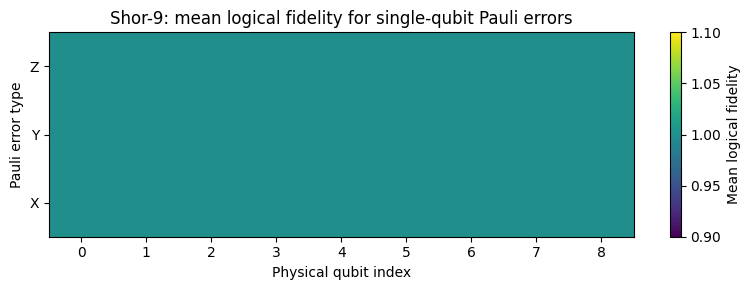

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))

im = plt.imshow(fidelity_map, aspect='auto', origin='lower',
                extent=[min(qubits)-0.5, max(qubits)+0.5, -0.5, len(paulis)-0.5])

plt.colorbar(im, label="Mean logical fidelity")

plt.yticks(range(len(paulis)), paulis)
plt.xticks(qubits)

plt.xlabel("Physical qubit index")
plt.ylabel("Pauli error type")
plt.title("Shor-9: mean logical fidelity for single-qubit Pauli errors")

plt.tight_layout()
plt.show()


This should be the final test to prove our Shor9 qubit correction code works for any arbitrary single-pauli error.

In [46]:
import numpy as np

# We assume:
# - shor_single_round(alpha, beta, error_dict, verbose=False) is defined
# - random_logical_state(rng) is defined (as before)

rng = np.random.default_rng(2025)

num_qubits = 9
qubits = list(range(num_qubits))

n_trials_per_pair = 30  

# fidelity_2err[i, j] = mean fidelity for two Pauli errors on qubits i and j
fidelity_2err = np.zeros((num_qubits, num_qubits), dtype=float)

for i in range(num_qubits):
    for j in range(i, num_qubits):   # only i <= j, then symmetrize
        if i == j:
            # optional: "two errors on same qubit" is ambiguous; we can just skip or set NaN
            fidelity_2err[i, j] = np.nan
            continue

        fidelities = []
        for _ in range(n_trials_per_pair):
            # random logical state
            alpha, beta = random_logical_state(rng)

            # random Pauli types for the two qubits
            P1, P2 = rng.choice(['X', 'Y', 'Z'], size=2)

            err = {i: P1, j: P2}
            res = shor_single_round(alpha, beta, err, verbose=False)
            fidelities.append(res["F"])

        mean_F = float(np.mean(fidelities))
        fidelity_2err[i, j] = mean_F
        fidelity_2err[j, i] = mean_F  # symmetry

fidelity_2err


array([[       nan, 0.78142492, 0.54895369, 0.04358438, 0.0220234 ,
        0.        , 0.00086932, 0.01290958, 0.03157236],
       [0.78142492,        nan, 0.83236508, 0.06193317, 0.09586898,
        0.02066625, 0.00241299, 0.02624284, 0.05261016],
       [0.54895369, 0.83236508,        nan, 0.02592094, 0.00545464,
        0.00085816, 0.02106051, 0.05643815, 0.03337924],
       [0.04358438, 0.06193317, 0.02592094,        nan, 0.82220258,
        0.76247449, 0.01978143, 0.05751077, 0.02306473],
       [0.0220234 , 0.09586898, 0.00545464, 0.82220258,        nan,
        0.81652348, 0.01200788, 0.02372814, 0.07313934],
       [0.        , 0.02066625, 0.00085816, 0.76247449, 0.81652348,
               nan, 0.03717951, 0.00694264, 0.00700734],
       [0.00086932, 0.00241299, 0.02106051, 0.01978143, 0.01200788,
        0.03717951,        nan, 0.83820877, 0.76053996],
       [0.01290958, 0.02624284, 0.05643815, 0.05751077, 0.02372814,
        0.00694264, 0.83820877,        nan, 0.78091011],


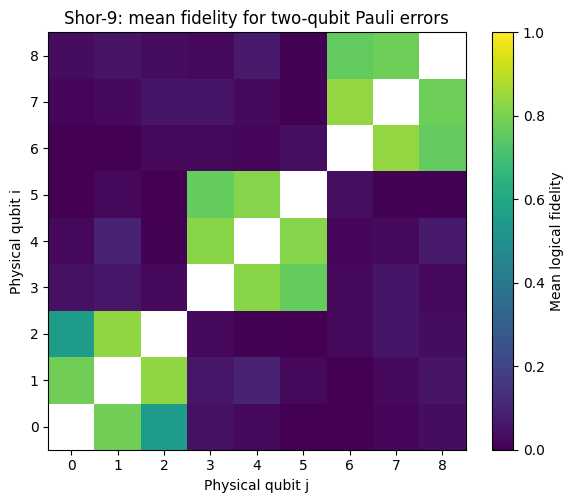

In [47]:
plt.figure(figsize=(6, 5))

# Mask diagonal if you set it to NaN (to hide it in the color scale)
data = np.ma.array(fidelity_2err, mask=np.isnan(fidelity_2err))

im = plt.imshow(
    data,
    origin='lower',
    aspect='equal',
    vmin=0.0,
    vmax=1.0
)

plt.colorbar(im, label="Mean logical fidelity")

plt.xticks(range(num_qubits), range(num_qubits))
plt.yticks(range(num_qubits), range(num_qubits))

plt.xlabel("Physical qubit j")
plt.ylabel("Physical qubit i")
plt.title("Shor-9: mean fidelity for two-qubit Pauli errors")

plt.tight_layout()
plt.show()